# ENTREGABLE RNN

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pytube import YouTube
import os

## Función para extraer frames de un vídeo



In [17]:
def extract_frames(video_path, num_frames=20):
    """
    Extrae un número fijo de frames equiespaciados de un vídeo.
    Args:
        video_path (str): Ruta al archivo de vídeo.
        num_frames (int): Número de frames a extraer.
    Returns:
        frames (list): Lista de arrays de imagen (frames extraídos).
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames

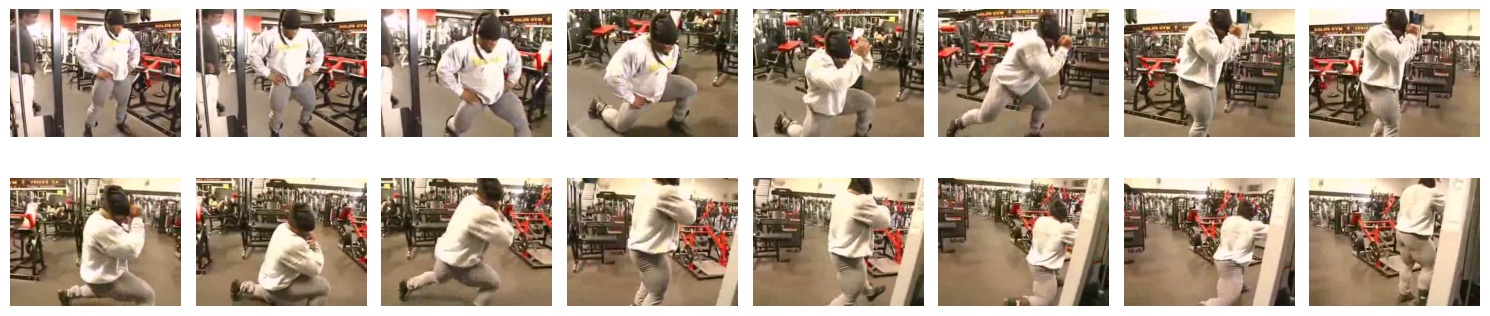

In [18]:
# Ruta a un video de ejemplo
video_path = "UCF50/UCF50/Lunges/v_Lunges_g01_c01.avi"

frames = extract_frames(video_path, num_frames=16)

# Visualizamos los frames extraídos
plt.figure(figsize=(15, 4))
for i, frame in enumerate(frames):
    plt.subplot(2, 8, i+1)
    plt.imshow(frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocesado de videos

In [19]:
def preprocess_video(video_path, num_frames=16, size=(112, 112)):
    """
    Extrae, redimensiona y normaliza los frames de un vídeo.
    Args:
        video_path (str): Ruta al archivo de vídeo.
        num_frames (int): Número de frames a extraer.
        size (tuple): Tamaño al que redimensionar cada frame (ancho, alto).
    Returns:
        np.ndarray: Array de shape (num_frames, alto, ancho, 3) listo para el modelo.
    """
    frames = extract_frames(video_path, num_frames=num_frames)
    processed = []
    for frame in frames:
        frame_resized = cv2.resize(frame, size)
        frame_norm = frame_resized / 255.0  # Normaliza a [0, 1]
        processed.append(frame_norm)
    return np.array(processed)

## Preparación del dataset para entrenamiento



In [20]:
# Selecciona 5 deportes/clases para el ejemplo
selected_classes = ['Benchpress', 'PullUps', 'JumpingJack', 'Lunges', 'PushUps']
'''
He probado con 5 clases parecidas a ver como responde el modelo
'''

# Directorio base del dataset
base_dir = "UCF50/UCF50"

# Listas para almacenar los datos y las etiquetas
X = []  # vídeos preprocesados
y = []  # etiquetas (números)

# Asignamos un número a cada clase
class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

# Recorremos cada clase seleccionada
for cls in selected_classes:
    class_dir = os.path.join(base_dir, cls)
    for video_file in os.listdir(class_dir):
        if video_file.endswith('.avi'):
            video_path = os.path.join(class_dir, video_file)
            try:
                video_array = preprocess_video(video_path, num_frames=16, size=(112, 112))
                if video_array.shape == (16, 112, 112, 3):  # Solo añadimos si el shape es correcto
                    X.append(video_array)
                    y.append(class_to_idx[cls])
            except Exception as e:
                print(f"Error procesando {video_path}: {e}")

# Convertimos a arrays de numpy
X = np.array(X)
y = np.array(y)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Clases: {class_to_idx}")

Shape de X: (648, 16, 112, 112, 3)
Shape de y: (648,)
Clases: {'Benchpress': 0, 'PullUps': 1, 'JumpingJack': 2, 'Lunges': 3, 'PushUps': 4}


## División del dataset en entrenamiento y test


In [21]:
# División en train y test
y_cat = to_categorical(y, num_classes=len(selected_classes))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (518, 16, 112, 112, 3)
Shape X_test: (130, 16, 112, 112, 3)
Shape y_train: (518, 5)
Shape y_test: (130, 5)


## Definición del modelo CNN + LSTM



In [22]:
model = Sequential()
# Extracción de características espaciales con CNN
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(16, 112, 112, 3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(Flatten()))
# Modelado temporal con LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
# Capa de salida
model.add(Dense(len(selected_classes), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (937727285.py, line 9)

## Entrenamiento del modelo

In [15]:
# Definimos early stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
epochs = 30
batch_size = 8
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop]
)

NameError: name 'EarlyStopping' is not defined

## Evaluación del modelo y visualización de resultados



5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9568 - loss: 0.1255
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9568 - loss: 0.1255

Test Loss: 0.0957  |  Test Accuracy: 0.9692
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step

Classification Report:
              precision    recall  f1-score   support

  Benchpress       0.97      1.00      0.98        32
     PullUps       1.00      1.00      1.00        24
 JumpingJack       1.00      1.00      1.00        25
      Lunges       0.96      0.89      0.93        28
     PushUps       0.91      0.95      0.93        21

    accuracy                           0.97       130
   macro avg       0.97      0.97      0.97       130
weighted avg       0.97      0.97      0.97       130


Test Loss: 0.0957  |  Test Accuracy: 0.9692
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step

Classification Report:
              precision    recall  f1-score   support

  Benchpress       0.97      1.00      0.98        32
     PullUps       1.00      1.00      1

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9568 - loss: 0.1255
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9568 - loss: 0.1255

Test Loss: 0.0957  |  Test Accuracy: 0.9692
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step

Classification Report:
              precision    recall  f1-score   support

  Benchpress       0.97      1.00      0.98        32
     PullUps       1.00      1.00      1.00        24
 JumpingJack       1.00      1.00      1.00        25
      Lunges       0.96      0.89      0.93        28
     PushUps       0.91      0.95      0.93        21

    accuracy                           0.97       130
   macro avg       0.97      0.97      0.97       130
weighted avg       0.97      0.97      0.97       130


Test Loss: 0.0957  |  Test Accuracy: 0.9692
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step

Classification Report:
              precision    recall  f1-score   support

  Benchpress       0.97      1.00      0.98        32
     PullUps       1.00      1.00      1

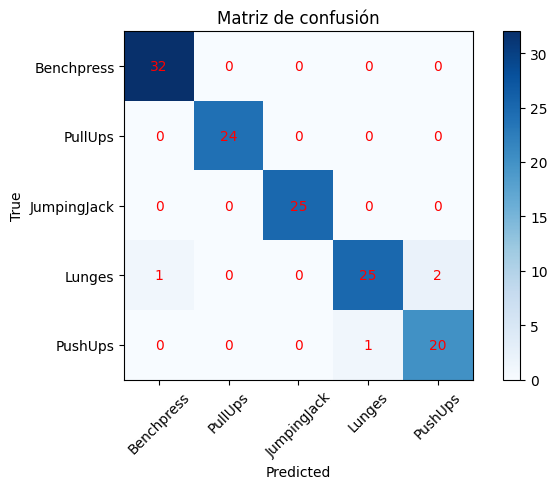

In [22]:
# Evaluación del modelo
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {loss:.4f}  |  Test Accuracy: {acc:.4f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=selected_classes))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(7,5))
plt.imshow(cm, cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(len(selected_classes)), labels=selected_classes, rotation=45)
plt.yticks(ticks=range(len(selected_classes)), labels=selected_classes)
for i in range(len(selected_classes)):
    for j in range(len(selected_classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.colorbar()
plt.tight_layout()
plt.show()

## Curvas de entrenamiento y validación (Overfitting/Underfitting)


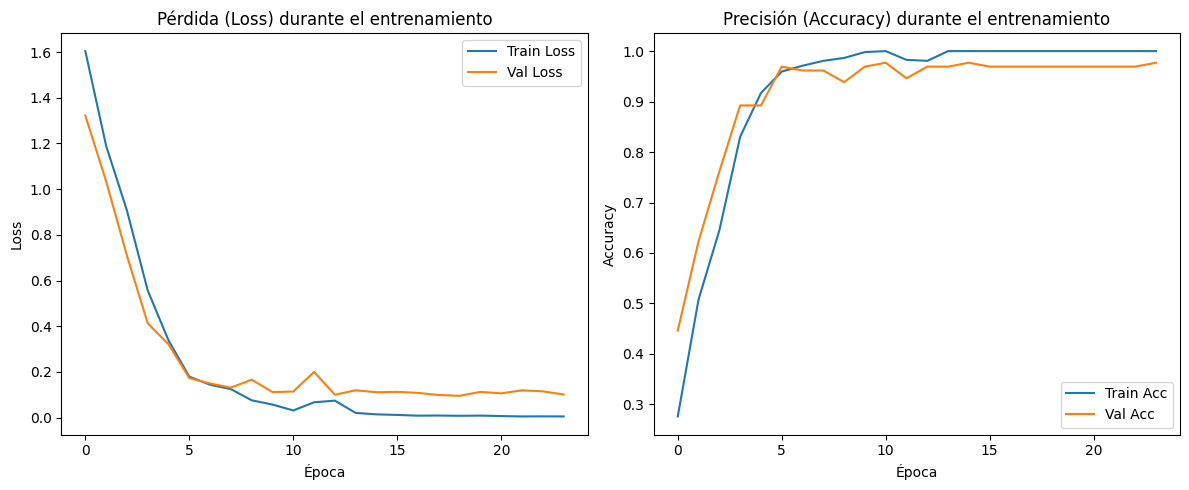

In [21]:
# Gráfica de loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Gráfica de accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión (Accuracy) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Inferencia desde una URL de YouTube


In [20]:
import yt_dlp

def download_youtube_video_yt_dlp(youtube_url, output_path='downloads', filename='video_test.mp4'):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    ydl_opts = {
        'outtmpl': os.path.join(output_path, filename),
        'format': 'mp4[ext=mp4]/bestvideo+bestaudio/best',
        'quiet': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])
    return os.path.join(output_path, filename)

def infer_video_class(video_path, model, class_names, num_frames=16, size=(112, 112)):
    """
    Realiza la inferencia de la clase de un vídeo dado.
    Args:
        video_path (str): Ruta al archivo de vídeo.
        model: Modelo entrenado (CNN+LSTM).
        class_names (list): Lista de nombres de las clases.
        num_frames (int): Número de frames a extraer.
        size (tuple): Tamaño de los frames.
    Returns:
        str: Nombre de la clase predicha.
    """
    video_array = preprocess_video(video_path, num_frames=num_frames, size=size)
    if video_array.shape != (num_frames, size[0], size[1], 3):
        raise ValueError(f"El vídeo no tiene el shape esperado: {video_array.shape}")
    video_array = np.expand_dims(video_array, axis=0)
    pred = model.predict(video_array)
    pred_class = np.argmax(pred, axis=1)[0]
    return class_names[pred_class]


# Opción 1: Inferencia sobre un vídeo local
ruta_video_local = "UCF50/UCF50/BenchPress/v_BenchPress_g01_c01.avi"  # Cambia por tu ruta
clase_predicha_local = infer_video_class(ruta_video_local, model, selected_classes)
print(f"Predicción para vídeo local: {clase_predicha_local}")

# Opción 2: Inferencia sobre un vídeo de YouTube
youtube_url = "https://www.youtube.com/watch?v=hIkeJVV-Djk"  # Cambia por la URL que quieras
ruta_descargada = download_youtube_video_yt_dlp(youtube_url)
clase_predicha_youtube = infer_video_class(ruta_descargada, model, selected_classes)
print(f"Predicción para vídeo de YouTube: {clase_predicha_youtube}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicción para vídeo local: Lunges
Predicción para vídeo local: Lunges
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicción para vídeo de YouTube: Lunges
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicción para vídeo de YouTube: Lunges
